# Deforestation Risk Index - Output

This notebook takes the best model from model_selection.ipynb, and runs the 2020 distubances through it to generate the 2021 disturbances.

### Note: (Neeraj and Paola to comment)
The best performing model on the test set was that achieved when training only on the features with a correlation of 0.1 or more with the deforestation variable. However, it provides too little variation on the prediction data: more than 25% of the estimates are 0, and the median is very low (0.0495%)

For the purpose of this exercise however, being able to visualise on the interface variability in the deforestation likelihood between areas provides a value added. For this reason, I have chosen instead to use the subset of features with 0.05 correlation or higher. That is the one currently displayed in the development platform

In [17]:
from joblib import load
import pandas as pd
import json
import os
import matplotlib.pyplot as plt
import rasterio

# Helpers

In [2]:
# from modedl selection notebook
# drop prefix of each dataframe column
def drop_prefix(self, prefix):
    self.columns = [i[-1]for i in self.columns.str.split(prefix, 1)]
    #self.columns = self.columns.str.strip(prefix)
    return self

pd.core.frame.DataFrame.drop_prefix = drop_prefix

# prepare X and y split
def split_set(df, drop_cols, y_var = 'deforestation_share'):
    X_split = df.drop(columns = drop_cols)
    y_split = df[y_var].copy()
    return X_split, y_split

def drop_non_forest(df, forest_col ='closed_forest_mask_ds'):
    return df[df[forest_col]>0]

def balance_classes(df, y_var = 'deforestation_share'):
    x = df[df[y_var]>0]
    y = df[df[y_var]==0].sample(n=int(len(x)/0.3), random_state=1)
    x = x.append(y)
    return x
    

In [3]:
def shape_pred_data(test):
    # remove column prefixes
    test.drop_prefix('national_');
    # drop non forest points
    test = drop_non_forest(test, forest_col ='closed_forest_mask_ds')
    # coordinates
    coords = test[['x', 'y']]
    # split features and target variable
    drop_cols =['aoi_ds',
                'year',
                'deforestation_share',
                'distance_to_deforestation',
                'x',
                'y']
    deforestation_vars = ['deforestation_share_1_lag',
                          'distance_to_deforestation_1_lag']
    y_var = 'deforestation_share'

    X_test, y_test = split_set(test, drop_cols, y_var)
    X_test['deforestation_share_1_lag']=y_test
    return X_test, coords

In [4]:
def predict(reg, X_pred):
    return reg.predict(X_pred)

In [5]:
def save_preds(y_hat, coords, coords_full, xsize, ysize, flnme):
    # combine y_hat and its coorddinates
    df = coords[['x', 'y']]
    df['z']= y_hat
    # merge with all coordinates of CdI
    print('Merging ...')
    pred_full =coords_full.merge(df, on = ['x','y'], how = 'left')
    pred_full['z'] = pred_full['z'].fillna(-1)
    # save as .xyz to later rasterise
    print('Saving .xyz .....')
    pred_full.to_csv(f'output/{flnme}.xyz', index = False)
    #rasterize the .xyz file
    print('Rasterizing ...')
    cmd = f'gdal_translate -outsize {xsize} {ysize} -a_srs EPSG:32629 output/{flnme}.xyz output/{flnme}.tif -co COMPRESS=LZW'
    os.system(cmd)
    print('Done!')
    return

# 1. Load data
## 1.1. Models

In [6]:
models = load('output/dri_model.joblib')

## 1.2. Prediction data

In [7]:
# load prediction set
test = pd.read_csv('output/national_training_2020.csv')

In [8]:
# shape prediction set
X_pred, coords = shape_pred_data(test)

In [9]:
# features subset
features_subset = json.load(open('output/features_subsets.json'))

## 1.3. Coordinates of full raster

In [10]:
# full coordinates covering the whole country 100m resolution
coords_full = pd.read_csv('intermediate/national/time_invariant.csv', usecols = ['x', 'y']) # training data includes only points within CDI borders


In [11]:
# gridded coordinates
coords_full = coords_full.sort_values(by = ['y','x'], ascending = (False,True))

# 2.  Make 2021 predictions

Make predictions for each feature subset on the best fitted model

In [12]:
preds = {}
for subset, cols in features_subset.items():
    y_hat = predict(models[subset], X_pred[cols])
    preds.update({subset:y_hat})
    # describe predictions
    print(subset)
    print(pd.DataFrame(y_hat).describe(),'\n')
    

all
                  0
count  2.935273e+06
mean   2.819697e-02
std    2.661945e-02
min    0.000000e+00
25%    6.115696e-03
50%    2.377410e-02
75%    4.115701e-02
max    4.100299e-01 

corr_0.025
                  0
count  2.935273e+06
mean   2.992258e-02
std    3.267095e-02
min    0.000000e+00
25%    2.784790e-04
50%    2.126721e-02
75%    4.765795e-02
max    4.056749e-01 

corr_0.05
                  0
count  2.935273e+06
mean   2.531408e-02
std    3.489961e-02
min    0.000000e+00
25%    1.377601e-04
50%    1.662141e-02
75%    3.362128e-02
max    7.285676e-01 

corr_0.1
                  0
count  2.935273e+06
mean   1.399855e-02
std    3.036259e-02
min    0.000000e+00
25%    0.000000e+00
50%    4.958676e-04
75%    1.358679e-02
max    6.774655e-01 



### Note: (Neeraj and Paola to comment)
The best performing model on the test set was that achieved when training only on the features with a correlation of 0.1 or more with the deforestation variable. However, it provides too little variation on the prediction data: more than 25% of the estimates are 0, and the median is very low (0.0495%)

For the purpose of this exercise however, being able to visualise on the interface variability in the deforestation likelihood between areas provides a value added. For this reason, I have chosen instead to use the subset of features with 0.05 correlation or higher. That is the one currently displayed in the development platform

# 3. Rasterize outputs

In [13]:
for subs, y_hat in preds.items():
    flnme = f'dri_2021_{subs}'
    print(f'Processing...{flnme}')
    save_preds(y_hat, coords, coords_full, 6723, 7070, flnme)

Processing...dri_2021_all
Merging ...
Saving .xyz .....
Rasterizing ...
Done!
Processing...dri_2021_corr_0.025
Merging ...
Saving .xyz .....
Rasterizing ...
Done!
Processing...dri_2021_corr_0.05
Merging ...
Saving .xyz .....
Rasterizing ...
Done!
Processing...dri_2021_corr_0.1
Merging ...
Saving .xyz .....
Rasterizing ...
Done!


# 4. Inspect results

all


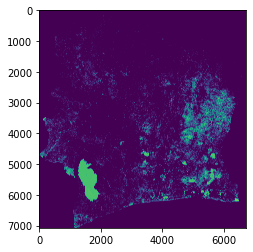

corr_0.025


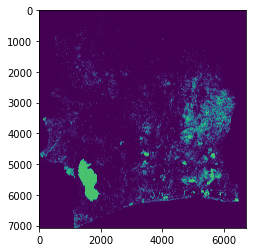

corr_0.05


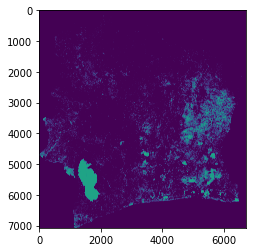

corr_0.1


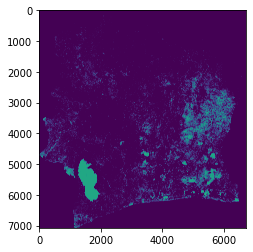

In [19]:
for subs in preds:
    flnme = f'dri_2021_{subs}'
    print(subs)
    plt.imshow(rasterio.open(f'output/{flnme}.tif').read(1))
    plt.show(block=False)